### Name: Thi Thach Thao Tran
Student ID: 47764554

# Portfolio 4 - Stroke Prediction Dataset

*Data source:* https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset

**Dataset Description：**
According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths.
This dataset is used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status. Each row in the data provides relevant information about the patient.


**Dataset Detail Information**
The dataset contains 5110 records in total. Every record has 11 features and 1 output variable which are described as below. 

- `id`: unique identifier
- `gender`: "Male", "Female" or "Other"
- `age`: age of the patient
- `hypertension`: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
- `heart_disease`: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
- `ever_married`: "No" or "Yes"
- `work_type`: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
- `Residence_type`: "Rural" or "Urban"
- `avg_glucose_level`: average glucose level in blood
- `bmi`: body mass index
- `smoking_status`: "formerly smoked", "never smoked", "smokes" or "Unknown"*
- `stroke`: 1 if the patient had a stroke or 0 if not
*Note: "Unknown" in smoking_status means that the information is unavailable for this patient

### List of questions:
- Are there any correlation between parameters as age, heart_disease, bmi and stroke? Any unexpected correlation between stroke and social status (such as residence type, work type). 
- Predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status.

### Data exploration

In [1]:
## Import Packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as ex
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score
from sklearn.feature_selection import RFE

from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score, KFold, RepeatedStratifiedKFold,StratifiedKFold
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
## Load Dataset
data = pd.read_csv('files/healthcare-dataset-stroke-data.csv')
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
data.shape

(5110, 12)

In [4]:
#As we don't use `id` in prediction, we will drop this column:
data=data.drop('id', axis=1)
data.shape

(5110, 11)

After loading the dataset into the notebook, we further check basic information of the dataset.

In [5]:
data.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [6]:
#identify the missing values and data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [7]:
#mention the column name and count of missing values:
data.isnull().sum().loc[data.isnull().any()]

bmi    201
dtype: int64

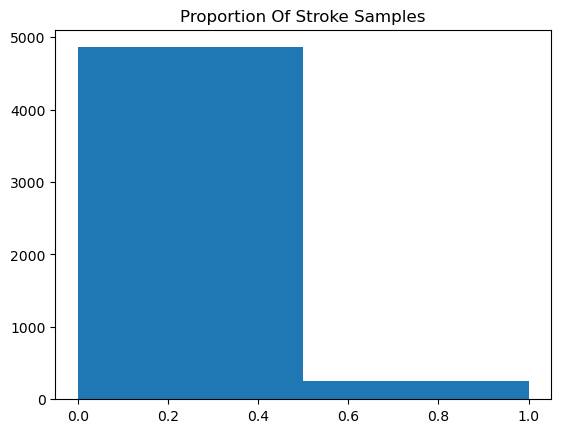

In [8]:
# univariate analysis
# Check proportions of stroke samples in the whole dataset: 
plt.hist(data['stroke'], bins= 2)
plt.title('Proportion Of Stroke Samples')
plt.show()

From the above chart, it can be seen that we are dealing with an **imbalanced dataset.** We see that the target is skewed and thus the best metric for this binary classification problem would be Area Under the ROC Curve (AUC).

In [9]:
# univariate analysis
data['age'].describe()

count    5110.000000
mean       43.226614
std        22.612647
min         0.080000
25%        25.000000
50%        45.000000
75%        61.000000
max        82.000000
Name: age, dtype: float64

(array([434., 362., 440., 484., 597., 583., 686., 559., 407., 558.]),
 array([8.0000e-02, 8.2720e+00, 1.6464e+01, 2.4656e+01, 3.2848e+01,
        4.1040e+01, 4.9232e+01, 5.7424e+01, 6.5616e+01, 7.3808e+01,
        8.2000e+01]),
 <BarContainer object of 10 artists>)

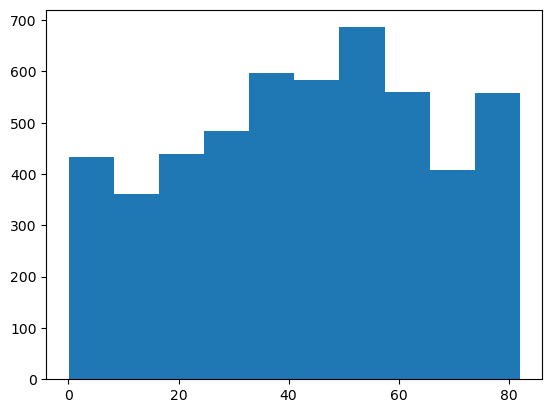

In [10]:
# univariate analysis 
plt.hist(data['age'], bins= 10)

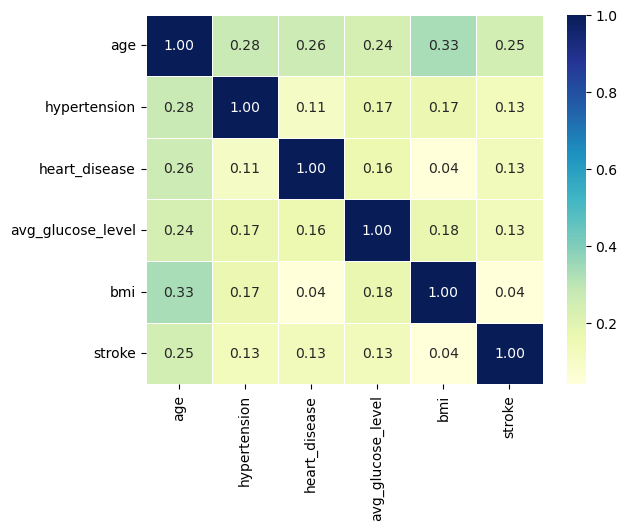

In [11]:
#bi-variate analysis
# Calculate correlation between columns
correlation = data.corr()
 
# Plotting the heatmap
sns.heatmap(correlation, annot=True, linewidth=0.5, cmap="YlGnBu", fmt = ".2f")
plt.show()

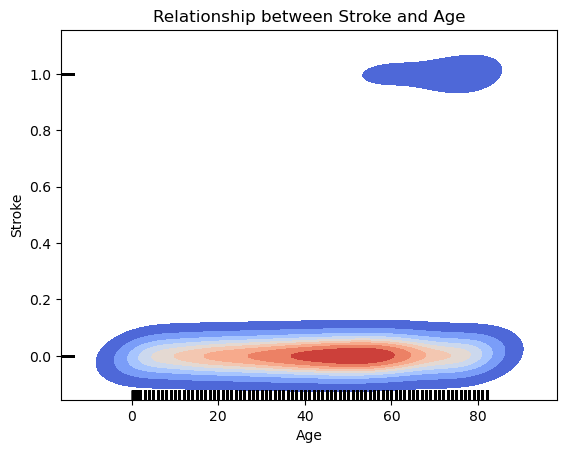

In [12]:
# Show relationship between Stroke and Age:
# Create KDE plot
sns.kdeplot(data=data, x=data.age, y=data.stroke, cmap='coolwarm', shade=True)
sns.rugplot(data=data, x=data.age, y=data.stroke, color='black')
plt.xlabel('Age')
plt.ylabel('Stroke')
plt.title('Relationship between Stroke and Age')

# Show plot
plt.show()

Based on the above plots (Heatmap and KDE plot), it seems clear that Age is a big factor in stroke patients - the older you get the more at risk you are.

Though less obvious, there are also differences in Avg. Glucose Levels, Hypertension, Heart disease	and small relation to BMI.

### Data preparation

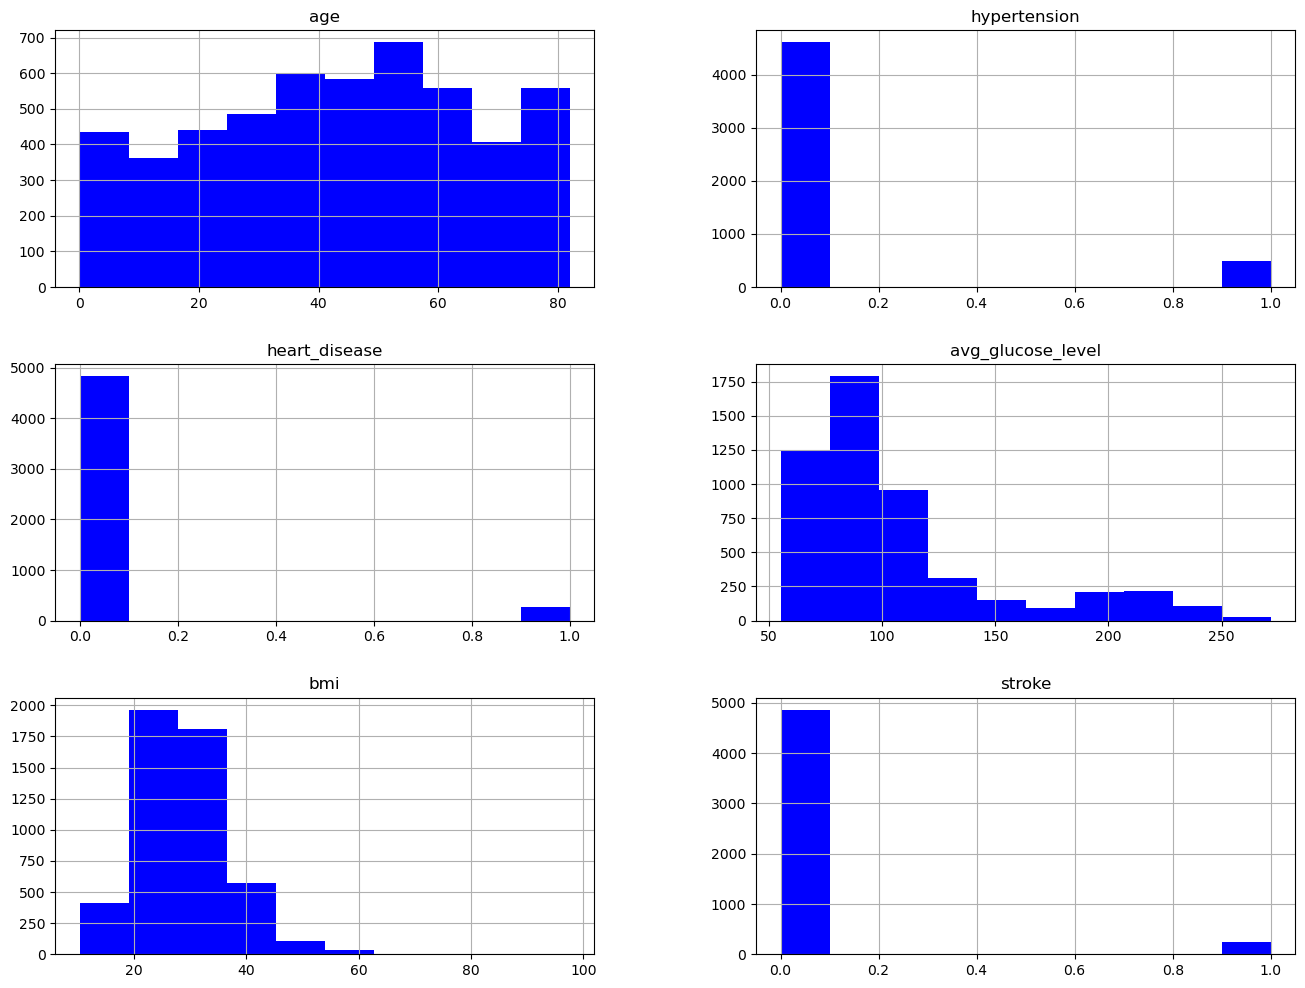

In [13]:
#histogram of all columns in the dataset
data.hist(bins=10 ,figsize=(16,12), color = 'Blue')
plt.show()

In [14]:
# missing value treatment: replace the missing values with mean value of its column
data['bmi'].fillna((data['bmi'].mean()), inplace=True)
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1


In [15]:
#Remove outliers
#remove 'avg_glucose_level' >= 250
Data_removed_outlier = data.drop(data[data['avg_glucose_level'] >= 250].index)
len(Data_removed_outlier)

#remove 'bmi' >= 80
clean_data = Data_removed_outlier.drop(Data_removed_outlier[Data_removed_outlier['bmi'] >= 70].index)
len(clean_data)

5081

<AxesSubplot:title={'center':'Outliers removed'}, xlabel='Features', ylabel='Values'>

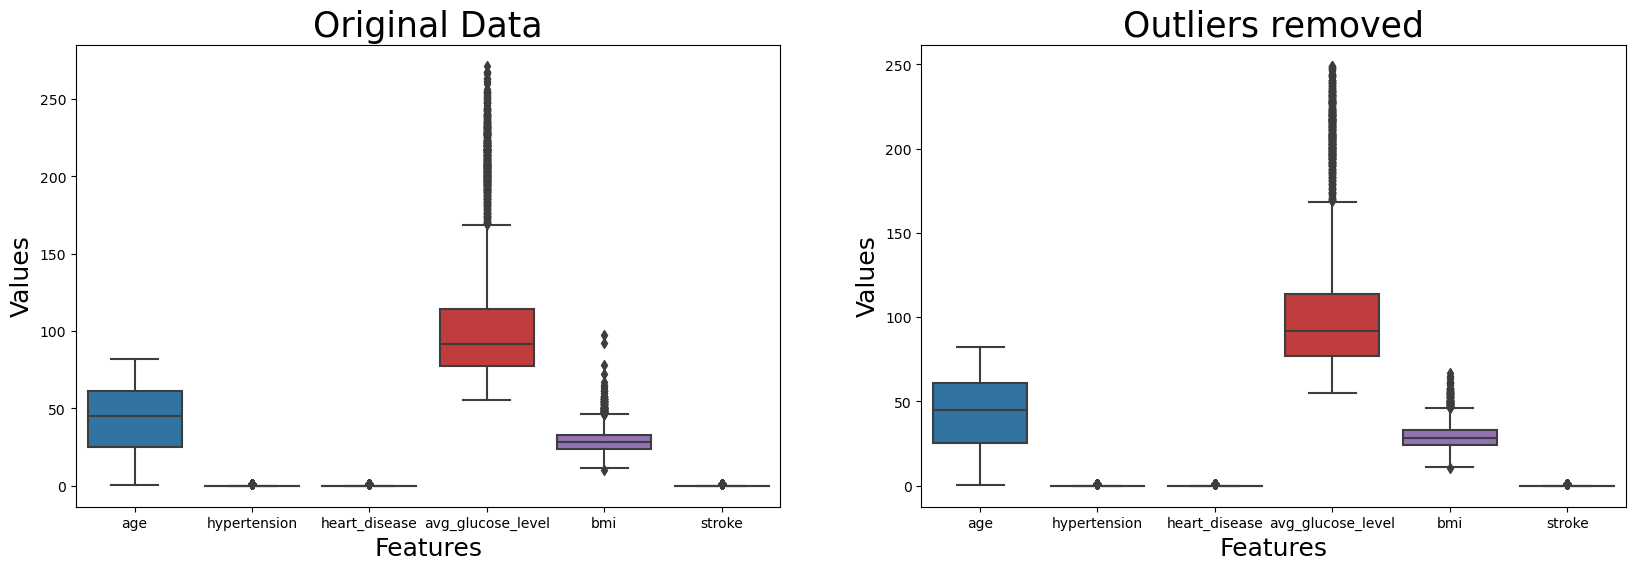

In [16]:
# create a single figure with two subplots
# original data
plt.figure(figsize = (20,6))
plt.subplot(1,2,1)
plt.xlabel('Features', size = 18)
plt.ylabel('Values', size = 18)
plt.title('Original Data', size = 25)
sns.boxplot(data = data)

# outliers removed
plt.subplot(1,2,2)
plt.xlabel('Features', size = 18)
plt.ylabel('Values', size = 18)
plt.title('Outliers removed', size = 25)
sns.boxplot(data = clean_data)

In [17]:
# Encoding categorical columns into indicator columns
clean_data['gender'] = clean_data['gender'].replace({'Male':0,'Female':1,'Other':-1}).astype(np.uint8)
clean_data['Residence_type'] = clean_data['Residence_type'].replace({'Rural':0,'Urban':1}).astype(np.uint8)
clean_data['work_type'] = clean_data['work_type'].replace({'Private':0,'Self-employed':1,'Govt_job':2,'children':-1,'Never_worked':-2}).astype(np.uint8)

# Print the first few rows of the new DataFrame
clean_data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,67.0,0,1,Yes,0,1,228.69,36.600000,formerly smoked,1
1,1,61.0,0,0,Yes,1,0,202.21,28.893237,never smoked,1
2,0,80.0,0,1,Yes,0,0,105.92,32.500000,never smoked,1
3,1,49.0,0,0,Yes,0,1,171.23,34.400000,smokes,1
4,1,79.0,1,0,Yes,1,0,174.12,24.000000,never smoked,1


### Logistic Regression

In [18]:
#check the number of records before and after Regression
clean_data.shape

(5081, 11)

#### Model 1:

In [19]:
# Model 1: Logistric Regression
X = clean_data[['gender','age','hypertension','heart_disease','work_type','avg_glucose_level','bmi']]
y = clean_data['stroke']
#apply analysis model on clean_data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))

X_train shape: (4064, 7)
y_train shape: (4064,)
X_test shape: (1017, 7)
y_test shape: (1017,)


In [20]:
# Training Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [21]:
# Doing predictions on train and test set
y_hat_train = model.predict(X_train)
y_hat_test = model.predict(X_test)

We see that the target is skewed and thus the best metric for this binary classification problem would be Area Under the ROC Curve (AUC).  It is not advisable to use accuracy as an evaluation metric, when dealing with higly imbalanced data.

In [22]:
# Evaluate the performance of trained model
print("Accuracy score on training set: ", accuracy_score(y_train, y_hat_train))
print("Accuracy score on testing set: ", accuracy_score(y_test, y_hat_test))
model1_acc = accuracy_score(y_test, y_hat_test)

Accuracy score on training set:  0.9547244094488189
Accuracy score on testing set:  0.9410029498525073


As this dataset is an imbalanced datasets, metrics like precision, recall, F1-score, and AUC-ROC can be used instead of accuracy.

In [23]:
# Calculate F1-score
print("F1-score on training set: ", f1_score(y_train, y_hat_train))
print("F1-score on testing set: ", f1_score(y_test, y_hat_test))
model1_f1 = f1_score(y_test, y_hat_test)

# Calculate AUC
y_pred_prob_train = model.predict_proba(X_train)[:, 1]
y_pred_prob_test = model.predict_proba(X_test)[:, 1]
print("AUC-ROC on training set: ", roc_auc_score(y_train, y_pred_prob_train))
print("AUC-ROC on testing set: ", roc_auc_score(y_test, y_pred_prob_test))
model1_auc = roc_auc_score(y_test, y_pred_prob_test)

F1-score on training set:  0.0
F1-score on testing set:  0.0
AUC-ROC on training set:  0.8465416293142088
AUC-ROC on testing set:  0.8320794148380355


In [24]:
#use k-fold cross validation for testing accuracy estimation
model = LogisticRegression()
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=10)
# calculate the mean accuracy score
model1_cv = scores.mean()
model1_cv

0.8379890512978457

A high AUC score indicates that the model is good at ranking the positive samples higher than the negative samples in terms of predicted probabilities. This means that the model is able to correctly classify most of the positive and negative samples. However, a low F1-score indicates that the model is not doing well in terms of precision and/or recall, which can be caused by imbalanced class distribution, noisy or irrelevant features, or overfitting to the training data.

#### Model 2: Feature selection

In [25]:
# creating RFE object
lr_model = LogisticRegression()
rfe = RFE(estimator=lr_model, n_features_to_select=5, step=1)
rfe.fit(X_train, y_train)

RFE(estimator=LogisticRegression(), n_features_to_select=5)

In [27]:
# doing evaluation
y_test_hat = rfe.predict(X_test)
print("Accuracy score on test set: ", accuracy_score(y_test, y_test_hat))
model2_acc = accuracy_score(y_test, y_test_hat)

# Calculate F1-score
print("F1-score on training set: ", f1_score(y_train, y_hat_train))
print("F1-score on testing set: ", f1_score(y_test, y_test_hat))
model2_f1 = f1_score(y_test, y_hat_test)

# Calculate AUC
y_pred_prob_train = rfe.predict_proba(X_train)[:, 1]
y_pred_prob_test = rfe.predict_proba(X_test)[:, 1]
print("AUC-ROC on training set: ", roc_auc_score(y_train, y_pred_prob_train))
print("AUC-ROC on testing set: ", roc_auc_score(y_test, y_pred_prob_test))
model2_auc = roc_auc_score(y_test, y_pred_prob_test)

Accuracy score on test set:  0.9410029498525073
F1-score on training set:  0.0
F1-score on testing set:  0.0
AUC-ROC on training set:  0.8415326647243389
AUC-ROC on testing set:  0.8310170672239637


In [28]:
# summarize all features
for i in range(X_train.shape[1]):
    print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))

Column: 0, Selected True, Rank: 1.000
Column: 1, Selected True, Rank: 1.000
Column: 2, Selected True, Rank: 1.000
Column: 3, Selected True, Rank: 1.000
Column: 4, Selected False, Rank: 3.000
Column: 5, Selected False, Rank: 2.000
Column: 6, Selected True, Rank: 1.000


In [29]:
# to increment number of features, one at each time
acc_scores = []
for i in range(1,10):
    clf = LogisticRegression()
    rfe = RFE(estimator=clf, n_features_to_select=i)
    # training model
    rfe.fit(X_train, y_train)
    # predicting on test set
    y_pred = rfe.predict(X_test)
    acc_score = accuracy_score(y_test, y_pred)
    # print this
    print("Acc on test set using", i, "features: ", acc_score)
    # append to the list
    acc_scores.append(acc_score)

Acc on test set using 1 features:  0.9410029498525073
Acc on test set using 2 features:  0.9410029498525073
Acc on test set using 3 features:  0.9410029498525073
Acc on test set using 4 features:  0.9410029498525073
Acc on test set using 5 features:  0.9410029498525073
Acc on test set using 6 features:  0.9410029498525073
Acc on test set using 7 features:  0.9410029498525073
Acc on test set using 8 features:  0.9410029498525073
Acc on test set using 9 features:  0.9410029498525073


In [30]:
#use k-fold cross validation for testing accuracy estimation
model = LogisticRegression()
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=10)
# calculate the mean accuracy score
model2_cv = scores.mean()
model2_cv

0.8379890512978457

### Classification KNN

#### Model 3

In [31]:
#apply analysis model on clean_data 
X = clean_data[['gender','age','hypertension','heart_disease','work_type','avg_glucose_level','bmi']]
y = clean_data['stroke']

# Data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Create and training a KNN classifier model
clf = KNeighborsClassifier(n_neighbors = 9)
clf.fit(X_train, y_train)

# Use the model to predict testing data
y_pred = clf.predict(X_test)
model3_acc = accuracy_score(y_pred, y_test)
print('Accuracy of KNN: ', model3_acc)

# Calculate F1-score
print("F1-score on testing set: ", f1_score(y_test, y_pred))
model3_f1 = f1_score(y_test, y_pred)

# Calculate AUC
y_pred_prob_test = clf.predict_proba(X_test)[:, 1]
print("AUC-ROC on testing set: ", roc_auc_score(y_test, y_pred_prob_test))
model3_auc = roc_auc_score(y_test, y_pred_prob_test)

Accuracy of KNN:  0.9430255402750491
F1-score on testing set:  0.0
AUC-ROC on testing set:  0.6591235632183907


In [32]:
# Create a KNN classifier model and use k-fold cross validation for testing accuracy estimation
clf = KNeighborsClassifier(n_neighbors = 10)
scores = cross_val_score(clf, X, y, scoring='roc_auc', cv=10)
print('AUC for each round: \n', scores)
print('Average AUC: %.4f +- %.4f' % (scores.mean(), scores.std()))
model3_cv = scores.mean()

AUC for each round: 
 [0.74520661 0.71055901 0.72745342 0.68910973 0.7209022  0.75301309
 0.70389979 0.72288223 0.82541322 0.7572314 ]
Average AUC: 0.7356 +- 0.0363


#### Improve model 3 using GridSearchCV:

In [33]:
# Define search space for parameters
parameter_grid = {'n_neighbors': range(1, 135, 5)}

# Create the machine learning model
knn_clf = KNeighborsClassifier()
clf = GridSearchCV(knn_clf, parameter_grid, scoring='roc_auc', cv=10)
clf.fit(X_train, y_train)

# Identify the best parameter(s)
print('Best K value: ', clf.best_params_['n_neighbors'])
print('The AUC: ', clf.best_score_)

Best K value:  81
The AUC:  0.8373220568317057


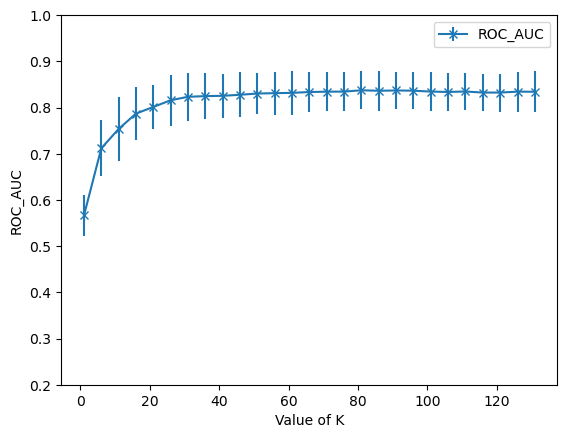

In [34]:
#visualize the relationship of K and AUC: 
cv_score_means = clf.cv_results_['mean_test_score']
cv_score_stds = clf.cv_results_['std_test_score']
k_range = range(1, 135, 5)

plt.errorbar(k_range, cv_score_means, yerr= cv_score_stds, marker='x', label='ROC_AUC')
plt.ylim(0.2, 1.0)
plt.xlabel('Value of K')
plt.ylabel('ROC_AUC')
plt.legend(loc='best')
plt.show()

#### Model 4

In [35]:
# Create and training a KNN classifier model with K=81
clf = KNeighborsClassifier(n_neighbors = 81)
clf.fit(X_train, y_train)

# Use the model to predict testing data
y_pred = clf.predict(X_test)
model4_acc = accuracy_score(y_pred, y_test)
print('Accuracy of KNN: ', model4_acc)

# Calculate F1-score
print("F1-score on testing set: ", f1_score(y_test, y_pred))
model4_f1 = f1_score(y_test, y_pred)

# Calculate AUC
y_pred_prob_test = clf.predict_proba(X_test)[:, 1]
print("AUC-ROC on testing set: ", roc_auc_score(y_test, y_pred_prob_test))
model4_auc = roc_auc_score(y_test, y_pred_prob_test)

Accuracy of KNN:  0.9430255402750491
F1-score on testing set:  0.0
AUC-ROC on testing set:  0.7851652298850575


In [36]:
# Create a KNN classifier model and use k-fold cross validation for testing accuracy estimation
clf = KNeighborsClassifier(n_neighbors = 81)
scores = cross_val_score(clf, X, y, scoring='roc_auc', cv=10)
print('AUC for each round: \n', scores)
print('Average AUC: %.4f +- %.4f' % (scores.mean(), scores.std()))
model4_cv = scores.mean()

AUC for each round: 
 [0.85735537 0.81962733 0.86414079 0.75792961 0.77849518 0.86587466
 0.81839704 0.83324725 0.8386708  0.82933023]
Average AUC: 0.8263 +- 0.0335


### Data visualisation

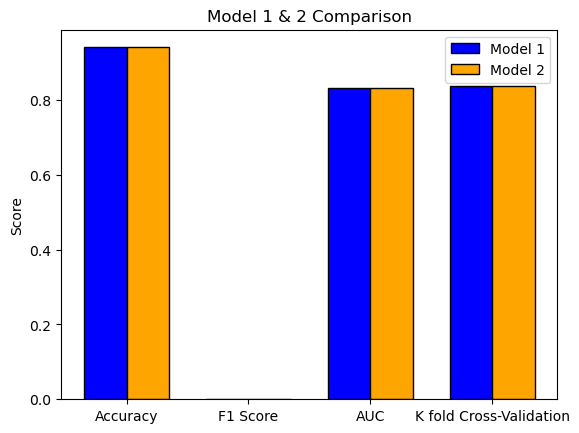

In [37]:
#Compare Model 1 and 2. 
# Set the x-axis labels
labels = ['Accuracy', 'F1 Score', 'AUC', 'K fold Cross-Validation']

# Set the y-axis data
model1_scores = [model1_acc, model1_f1, model1_auc, model1_cv]
model2_scores = [model2_acc, model2_f1, model2_auc, model2_cv]

# Set the bar width
bar_width = 0.35

# Set the x positions of the bars
r1 = np.arange(len(model1_scores))
r2 = [x + bar_width for x in r1]

# Create the bar plot
plt.bar(r1, model1_scores, color='blue', width=bar_width, edgecolor='black', label='Model 1')
plt.bar(r2, model2_scores, color='orange', width=bar_width, edgecolor='black', label='Model 2')

# Add labels and titles
plt.xticks([r + bar_width / 2 for r in range(len(model1_scores))], labels)
plt.ylabel('Score')
plt.title('Model 1 & 2 Comparison')

# Add legend
plt.legend()

# Show the plot
plt.show()

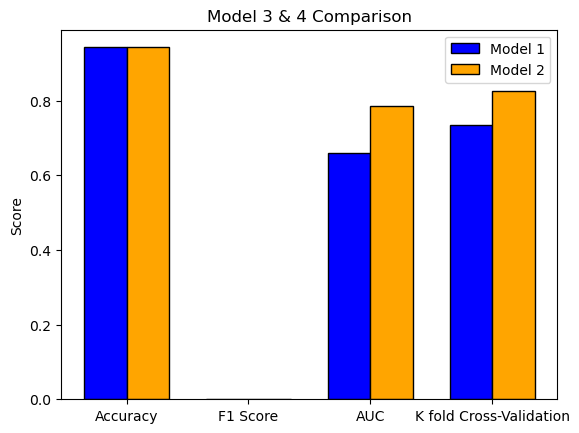

In [39]:
#Compare Model 3 and 4. 
# Set the x-axis labels
labels = ['Accuracy', 'F1 Score', 'AUC', 'K fold Cross-Validation']

# Set the y-axis data
model3_scores = [model3_acc, model3_f1, model3_auc, model3_cv]
model4_scores = [model4_acc, model4_f1, model4_auc, model4_cv]

# Set the bar width
bar_width = 0.35

# Set the x positions of the bars
r1 = np.arange(len(model3_scores))
r2 = [x + bar_width for x in r1]

# Create the bar plot
plt.bar(r1, model3_scores, color='blue', width=bar_width, edgecolor='black', label='Model 1')
plt.bar(r2, model4_scores, color='orange', width=bar_width, edgecolor='black', label='Model 2')

# Add labels and titles
plt.xticks([r + bar_width / 2 for r in range(len(model3_scores))], labels)
plt.ylabel('Score')
plt.title('Model 3 & 4 Comparison')

# Add legend
plt.legend()

# Show the plot
plt.show()

### Analysis

From the graph comparing Model 1 and Model 2, the results suggest that logistic regression achieves a similar estimation results in both Model 1 and 2. When we use Recursive Feature Elimination (RFE), we received the same accuracy score for all features between the numbers of features. This could be due to several reasons such as: Model underfitting or overfitting, Data imbalance, Not enough data, or Data noise or outliers. Hence, other metrics were used that are F1-score, ROC-AUC.

In Model 3 and Model 4, there is a significant improvement in the AUC and Cross-Validation Scores. This shows that tunning hyper-parameters using GridSearchCV can improve the KNN model by approximately 9% (from 0.7356 to 0.8263). 

_Discussion:_ 
Since this is an imbalanced dataset, the analysis and the performance of the model can be improved by other techniques such as Resampling (Oversampling, undersampling), Synthetic data generation (SMOTE), etc.

---END---